# Azure Document Intelligence Docker Layout API & phi-3

<img src="container.png" width=200>

> https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/containers/install-run?view=doc-intel-3.0.0&tabs=layout

## 1. Librairies

In [1]:
#%pip install azure-ai-formrecognizer

In [2]:
import datetime
import os
import openai
import sys
import platform
import time

from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv
from IPython.display import FileLink
from PIL import Image

In [3]:
import azure.ai.documentintelligence
print("Azure Document Intelligence version: ", azure.ai.documentintelligence.__version__)

Azure Document Intelligence version:  1.0.0b4


In [4]:
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 17-Dec-2024 15:08:31


In [6]:
def get_system_info():
    """
    Get system information
    """
    system_info = {
        "System": platform.system(),
        "Machine": platform.machine(),
        "Processor": platform.processor(),
    }
    return system_info


info = get_system_info()
for key, value in info.items():
    print(f"{key}: {value}")

System: Windows
Machine: AMD64
Processor: Intel64 Family 6 Model 141 Stepping 1, GenuineIntel


## 2. Settings for Azure Document Intelligence in a connected container

In [7]:
# Docker endpoint
endpoint = "http://localhost:5000"

In [8]:
load_dotenv("azure.env")

key = os.getenv("azure_doc_intelligence_key")

In [9]:
azure_document_intelligence_client = DocumentAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(key))
azure_document_intelligence_client

http://localhost:5000

http://localhost:5000/api-docs/index.html

## 3. Functions

In [10]:
def get_words(page, line):
    """
    Extracts words from a given page that fall within the specified line spans.

    Args:
        page (Page): The page object containing words to be extracted.
        line (Line): The line object containing spans that define the boundaries for word extraction.

    Returns:
        list: A list of words that are within the specified line spans.
    """
    result = []

    for word in page.words:
        if _in_span(word, line.spans):
            result.append(word)

    return result

In [11]:
def count_words_in_file(file_path):
    """
    Counts the number of words in a text file.

    Args:
        file_path (str): The path to the text file.

    Returns:
        int: The number of words in the file.
    """
    with open(file_path, 'r') as file:
        text = file.read()
        words = text.split()
        return len(words)

In [12]:
def _in_span(word, spans):
    """
    Checks if a word falls within any of the specified spans.

    Args:
        word (Word): The word object to be checked.
        spans (list): A list of span objects that define the boundaries for the word.

    Returns:
        bool: True if the word is within any of the spans, False otherwise.
    """
    for span in spans:
        if word.span.offset >= span.offset and (
                word.span.offset + word.span.length) <= (span.offset +
                                                         span.length):
            return True

    return False

In [13]:
def get_results(result):
    """
    Prints the Azure Document Intelligence results.

    This function prints detailed information about the document's layout, such as the presence of handwritten content, 
    the dimensions of each page, the lines and words within each page, selection marks, barcodes, and tables.

    Input: result
    Returns: None
    """
    print("Document Layout Analysis:")
    print("\033[1;31;34m")

    if result.styles and any([style.is_handwritten
                              for style in result.styles]):
        print("Document contains handwritten content\n")
    else:
        print("Document does not contain handwritten content\n")

    for page in result.pages:
        print(f"*** Analyzing layout from page #{page.page_number} ***")
        print(
            f"Page has width: {page.width} and height: {page.height}, measured with unit: {page.unit}"
        )
        print()

        if page.lines:
            for line_idx, line in enumerate(page.lines):
                words = get_words(page, line)
                print(
                    f"\n- Line # {line_idx} has word count {len(words)} and text '{line.content}' "
                    f"within bounding polygon '{line.polygon}'")

                for word in words:
                    print(
                        f"\tWord '{word.content}' has a confidence of {word.confidence}"
                    )

        if page.selection_marks:
            for selection_mark in page.selection_marks:
                print(
                    f"Selection mark is '{selection_mark.state}' within bounding polygon "
                    f"'{selection_mark.polygon}' and has a confidence of {selection_mark.confidence}"
                )

        if page.barcodes:
            print(f"Detected {len(page.barcodes)} barcodes:")
            for barcode_idx, barcode in enumerate(page.barcodes):
                print(f"Barcode #{barcode_idx}: {barcode.value}")
                print(f"\tKind: {barcode.kind}")
                print(f"\tConfidence: {barcode.confidence}")
                print(f"\tBounding regions: {barcode.polygon}")

    if result.tables:
        for table_idx, table in enumerate(result.tables):
            print(f"Table # {table_idx} has {table.row_count} rows and "
                  f"{table.column_count} columns")
            if table.bounding_regions:
                for region in table.bounding_regions:
                    print(
                        f"Table # {table_idx} location on page: {region.page_number} is {region.polygon}"
                    )
            for cell in table.cells:
                print(
                    f"Cell[{cell.row_index}][{cell.column_index}] has text '{cell.content}'"
                )
            if cell.bounding_regions:
                for region in cell.bounding_regions:
                    print(
                        f"content on page {region.page_number} is within bounding polygon '{region.polygon}'"
                    )

In [14]:
def azure_document_intelligence_costs(pages: int) -> float:
    """
    Calculate Azure Document Intelligence costs.
    The cost for Prebuilt Models (Layout) is $10 per 1,000 pages.

    Output in USD.
    """
    cost = 10 * (pages / 1_000)

    return cost

In [15]:
def phi3_ollama_model(prompt, temperature=0.7, model="phi3"):
    """
    Generates a response from the Phi-3 model using the Ollama API.

    Args:
        prompt (str): The input prompt to generate a response for.
        temperature (float, optional): The sampling temperature to use.
        Defaults to 0.7.

    Returns:
        str: The generated response from the model.
    """
    try:
        response = ollama_client.chat.completions.create(
            model=model,
            temperature=temperature,
            n=1,
            messages=[{
                "role": "system",
                "content": "You are an AI helpful assistant."
            }, {
                "role": "user",
                "content": prompt,
            }],
        )
        return response.choices[0].message.content

    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")
        return None

## 4. Tests

### Test 1

In [27]:
#document_file = "documents/azure.pdf"
document_file = "documents/azure_fr.pdf"

In [28]:
LINK = FileLink(path=document_file)
print("Click to download the file:")
LINK

Click to download the file:


C:\Users\seretkow\OneDrive - Microsoft\Démos\Azure Document Intelligence\Document Intelligence container\documents\azure_fr.pdf

In [29]:
start = time.time()

with open(document_file, "rb") as file:
    poller = azure_document_intelligence_client.begin_analyze_document("prebuilt-layout", file.read())
    result = poller.result()

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S.' + str(elapsed % 1)[2:15], time.gmtime(elapsed))}")

Done in 00:00:07.3244225978851


In [30]:
print(result)

AnalyzeResult(api_version=2023-07-31, model_id=prebuilt-layout, content=120
Guide d'Azure pour les développeurs
Mai 2019
Poursuivez votre apprentissage avec Azure
Avec votre compte Azure gratuit, vous bénéficiez de tout cela et vous ne serez facturé(e) que si vous optez pour une mise à niveau :
· 12 mois de services populaires gratuits.
· Crédit de 200 $ pour découvrir le service Azure de votre choix pendant 30 jours.
· + de 25 services toujours gratuits.
· Prise en main d'Azure : regardez ces courts tutoriels sur le mode d'utilisation d'Azure et commencez à développer des projets immédiatement. Vous pouvez également vous associer à notre webcast hebdomadaire qui propose des démonstrations des fonctionnalités de base Azure et donne accès à des experts en permanence.
· Microsoft Learn : acquérez de nouvelles compétences et découvrez la puissance des produits Microsoft grâce à des instructions détaillées. Lancez-vous dès aujourd'hui en explorant nos modules et parcours d'apprentissage.
·

In [31]:
result.api_version

'2023-07-31'

In [32]:
result.model_id

'prebuilt-layout'

In [33]:
print(result.content)

120
Guide d'Azure pour les développeurs
Mai 2019
Poursuivez votre apprentissage avec Azure
Avec votre compte Azure gratuit, vous bénéficiez de tout cela et vous ne serez facturé(e) que si vous optez pour une mise à niveau :
· 12 mois de services populaires gratuits.
· Crédit de 200 $ pour découvrir le service Azure de votre choix pendant 30 jours.
· + de 25 services toujours gratuits.
· Prise en main d'Azure : regardez ces courts tutoriels sur le mode d'utilisation d'Azure et commencez à développer des projets immédiatement. Vous pouvez également vous associer à notre webcast hebdomadaire qui propose des démonstrations des fonctionnalités de base Azure et donne accès à des experts en permanence.
· Microsoft Learn : acquérez de nouvelles compétences et découvrez la puissance des produits Microsoft grâce à des instructions détaillées. Lancez-vous dès aujourd'hui en explorant nos modules et parcours d'apprentissage.
· Azure Friday : consultez Azure Services et les fonctions avec l'équipe 

In [34]:
result.pages

[DocumentPage(page_number=1, angle=None, width=8.5, height=11.0, unit=inch, lines=[DocumentLine(content=120, polygon=[Point(x=7.6691, y=0.6589), Point(x=7.8315, y=0.6541), Point(x=7.8315, y=0.7543), Point(x=7.6691, y=0.7496)], spans=[DocumentSpan(offset=0, length=3)]), DocumentLine(content=Guide d'Azure pour, polygon=[Point(x=6.4753, y=0.6493), Point(x=7.3492, y=0.6541), Point(x=7.3444, y=0.7687), Point(x=6.4753, y=0.7591)], spans=[DocumentSpan(offset=4, length=18)]), DocumentLine(content=les développeurs, polygon=[Point(x=6.4705, y=0.7782), Point(x=7.2393, y=0.783), Point(x=7.2346, y=0.8928), Point(x=6.4705, y=0.8832)], spans=[DocumentSpan(offset=23, length=16)]), DocumentLine(content=Mai, polygon=[Point(x=5.5775, y=0.6541), Point(x=5.7638, y=0.6493), Point(x=5.7638, y=0.7496), Point(x=5.5823, y=0.7496)], spans=[DocumentSpan(offset=40, length=3)]), DocumentLine(content=2019, polygon=[Point(x=5.5775, y=0.7782), Point(x=5.7924, y=0.7734), Point(x=5.7972, y=0.8737), Point(x=5.5823, y=0.8

In [35]:
result.paragraphs

[DocumentParagraph(role=pageNumber, content=120, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=7.6691, y=0.6541), Point(x=7.8315, y=0.6541), Point(x=7.8315, y=0.7543), Point(x=7.6691, y=0.7543)])], spans=[DocumentSpan(offset=0, length=3)]),
 DocumentParagraph(role=pageHeader, content=Guide d'Azure pour les développeurs, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=6.4712, y=0.6493), Point(x=7.3492, y=0.6541), Point(x=7.3478, y=0.8934), Point(x=6.4699, y=0.8886)])], spans=[DocumentSpan(offset=4, length=35)]),
 DocumentParagraph(role=None, content=Mai 2019, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=5.5743, y=0.6542), Point(x=5.7914, y=0.6486), Point(x=5.7972, y=0.8737), Point(x=5.5801, y=0.8793)])], spans=[DocumentSpan(offset=40, length=8)]),
 DocumentParagraph(role=None, content=Poursuivez votre apprentissage avec Azure, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=0.6468, y=1.7334), Point(x=5.3743, y=1.67

In [36]:
get_results(result)

Document Layout Analysis:

Document does not contain handwritten content

*** Analyzing layout from page #1 ***
Page has width: 8.5 and height: 11.0, measured with unit: inch


- Line # 0 has word count 1 and text '120' within bounding polygon '[Point(x=7.6691, y=0.6589), Point(x=7.8315, y=0.6541), Point(x=7.8315, y=0.7543), Point(x=7.6691, y=0.7496)]'
	Word '120' has a confidence of 0.997

- Line # 1 has word count 3 and text 'Guide d'Azure pour' within bounding polygon '[Point(x=6.4753, y=0.6493), Point(x=7.3492, y=0.6541), Point(x=7.3444, y=0.7687), Point(x=6.4753, y=0.7591)]'
	Word 'Guide' has a confidence of 0.995
	Word 'd'Azure' has a confidence of 0.993
	Word 'pour' has a confidence of 0.993

- Line # 2 has word count 2 and text 'les développeurs' within bounding polygon '[Point(x=6.4705, y=0.7782), Point(x=7.2393, y=0.783), Point(x=7.2346, y=0.8928), Point(x=6.4705, y=0.8832)]'
	Word 'les' has a confidence of 0.993
	Word 'développeurs' has a confidence of 0.55

- Line # 3 has w

In [37]:
for idx, paragraph in enumerate(result.paragraphs, start=1):
    print(f"{idx}: {paragraph}\n")

1: DocumentParagraph(role=pageNumber, content=120, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=7.6691, y=0.6541), Point(x=7.8315, y=0.6541), Point(x=7.8315, y=0.7543), Point(x=7.6691, y=0.7543)])], spans=[DocumentSpan(offset=0, length=3)])

2: DocumentParagraph(role=pageHeader, content=Guide d'Azure pour les développeurs, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=6.4712, y=0.6493), Point(x=7.3492, y=0.6541), Point(x=7.3478, y=0.8934), Point(x=6.4699, y=0.8886)])], spans=[DocumentSpan(offset=4, length=35)])

3: DocumentParagraph(role=None, content=Mai 2019, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=5.5743, y=0.6542), Point(x=5.7914, y=0.6486), Point(x=5.7972, y=0.8737), Point(x=5.5801, y=0.8793)])], spans=[DocumentSpan(offset=40, length=8)])

4: DocumentParagraph(role=None, content=Poursuivez votre apprentissage avec Azure, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=0.6468, y=1.7334), Point(x=5.3743

### Test 2

In [38]:
#document_file = "documents/receipt.jpg"
document_file = "documents/facture.jpg"

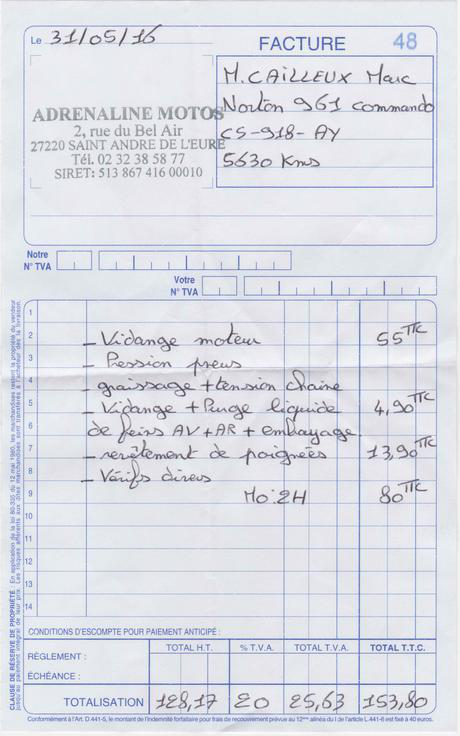

In [72]:
img = Image.open(document_file)
img

In [40]:
start = time.time()

with open(document_file, "rb") as file:
    poller = azure_document_intelligence_client.begin_analyze_document("prebuilt-layout", file.read())
    result = poller.result()

elapsed = time.time() - start
print(f"Done in {time.strftime('%H:%M:%S.' + str(elapsed % 1)[2:5], time.gmtime(elapsed))}")

Done in 00:00:02.090


In [41]:
get_results(result)

Document Layout Analysis:

Document contains handwritten content

*** Analyzing layout from page #1 ***
Page has width: 460.0 and height: 736.0, measured with unit: pixel


- Line # 0 has word count 1 and text '31/05/16' within bounding polygon '[Point(x=47.0, y=24.0), Point(x=160.0, y=24.0), Point(x=160.0, y=46.0), Point(x=47.0, y=46.0)]'
	Word '31/05/16' has a confidence of 0.979

- Line # 1 has word count 1 and text 'FACTURE' within bounding polygon '[Point(x=257.0, y=33.0), Point(x=347.0, y=33.0), Point(x=347.0, y=52.0), Point(x=257.0, y=51.0)]'
	Word 'FACTURE' has a confidence of 0.995

- Line # 2 has word count 1 and text '48' within bounding polygon '[Point(x=392.0, y=30.0), Point(x=418.0, y=30.0), Point(x=419.0, y=50.0), Point(x=392.0, y=50.0)]'
	Word '48' has a confidence of 0.997

- Line # 3 has word count 2 and text 'ADRENALINE MOTOS' within bounding polygon '[Point(x=30.0, y=104.0), Point(x=225.0, y=103.0), Point(x=225.0, y=121.0), Point(x=30.0, y=123.0)]'
	Word 'ADRENALINE

In [42]:
result.api_version

'2023-07-31'

In [43]:
result.model_id

'prebuilt-layout'

In [44]:
print(result.content)

31/05/16
FACTURE
48
ADRENALINE MOTOS 2, rue du Bel Air 27220 SAINT ANDRE DE L'EURE Tél. 02 32 38 58 77 SIRET: 513 867 416 00010
M. CAILLEUX Marc Norton 961 commando CS-918- AY 5630 Kms
Notre Nº TVA
Votre Nº TVA
-
Vidange moteur
55TTC
Pression pneus
graissage +tension chaine
5
Vidange + Purge liquide
4,90TTC
de feins AV + AR + embrayage
revêtement de poignées
13,90TTC
Várifs divers
CLAUSE DO RÉSERVE DE PROPRIÉTÉ : En application delaloi-33 12 90, les chances tent pole d verde
Mo:2H
8 TTC
11
12
13
CONDITIONS D'ESCOMPTE POUR PAIEMENT ANTICIPÉ
REGLEMENT ECHÉANCE :
TOTAL H.T.
% T.V.A.
TOTAL T.V.A.
TOTAL T.T.C.
TOTALISATION
128,17
20
25,63
153,80
Conformément à TArt. D:441-5, le montant de l'indeinte forfaitaire pour frais he reccowemint prévue au 12 ** alinéa du I de article L:441-1) intt Sch à 40 euros


In [45]:
result.pages

[DocumentPage(page_number=1, angle=None, width=460.0, height=736.0, unit=pixel, lines=[DocumentLine(content=31/05/16, polygon=[Point(x=47.0, y=24.0), Point(x=160.0, y=24.0), Point(x=160.0, y=46.0), Point(x=47.0, y=46.0)], spans=[DocumentSpan(offset=0, length=8)]), DocumentLine(content=FACTURE, polygon=[Point(x=257.0, y=33.0), Point(x=347.0, y=33.0), Point(x=347.0, y=52.0), Point(x=257.0, y=51.0)], spans=[DocumentSpan(offset=9, length=7)]), DocumentLine(content=48, polygon=[Point(x=392.0, y=30.0), Point(x=418.0, y=30.0), Point(x=419.0, y=50.0), Point(x=392.0, y=50.0)], spans=[DocumentSpan(offset=17, length=2)]), DocumentLine(content=ADRENALINE MOTOS, polygon=[Point(x=30.0, y=104.0), Point(x=225.0, y=103.0), Point(x=225.0, y=121.0), Point(x=30.0, y=123.0)], spans=[DocumentSpan(offset=20, length=16)]), DocumentLine(content=2, rue du Bel Air, polygon=[Point(x=71.0, y=122.0), Point(x=183.0, y=122.0), Point(x=184.0, y=137.0), Point(x=71.0, y=138.0)], spans=[DocumentSpan(offset=37, length=17)

In [46]:
for idx, page in enumerate(result.pages, start=1):
    print(f"{idx}: {page}\n")

1: DocumentPage(page_number=1, angle=None, width=460.0, height=736.0, unit=pixel, lines=[DocumentLine(content=31/05/16, polygon=[Point(x=47.0, y=24.0), Point(x=160.0, y=24.0), Point(x=160.0, y=46.0), Point(x=47.0, y=46.0)], spans=[DocumentSpan(offset=0, length=8)]), DocumentLine(content=FACTURE, polygon=[Point(x=257.0, y=33.0), Point(x=347.0, y=33.0), Point(x=347.0, y=52.0), Point(x=257.0, y=51.0)], spans=[DocumentSpan(offset=9, length=7)]), DocumentLine(content=48, polygon=[Point(x=392.0, y=30.0), Point(x=418.0, y=30.0), Point(x=419.0, y=50.0), Point(x=392.0, y=50.0)], spans=[DocumentSpan(offset=17, length=2)]), DocumentLine(content=ADRENALINE MOTOS, polygon=[Point(x=30.0, y=104.0), Point(x=225.0, y=103.0), Point(x=225.0, y=121.0), Point(x=30.0, y=123.0)], spans=[DocumentSpan(offset=20, length=16)]), DocumentLine(content=2, rue du Bel Air, polygon=[Point(x=71.0, y=122.0), Point(x=183.0, y=122.0), Point(x=184.0, y=137.0), Point(x=71.0, y=138.0)], spans=[DocumentSpan(offset=37, length=1

In [47]:
result.paragraphs

[DocumentParagraph(role=None, content=31/05/16, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=38.0, y=26.0), Point(x=216.0, y=26.0), Point(x=216.0, y=55.0), Point(x=38.0, y=56.0)])], spans=[DocumentSpan(offset=0, length=8)]),
 DocumentParagraph(role=None, content=FACTURE, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=216.0, y=26.0), Point(x=311.0, y=26.0), Point(x=310.0, y=55.0), Point(x=216.0, y=55.0)])], spans=[DocumentSpan(offset=9, length=7)]),
 DocumentParagraph(role=None, content=48, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=390.0, y=26.0), Point(x=435.0, y=26.0), Point(x=435.0, y=55.0), Point(x=390.0, y=55.0)])], spans=[DocumentSpan(offset=17, length=2)]),
 DocumentParagraph(role=None, content=ADRENALINE MOTOS 2, rue du Bel Air 27220 SAINT ANDRE DE L'EURE Tél. 02 32 38 58 77 SIRET: 513 867 416 00010, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=38.0, y=56.0), Point(x=216.0, y=55.0), Point(x=215.0, y

In [48]:
for idx, paragraph in enumerate(result.paragraphs, start=1):
    print(f"{idx}: {paragraph}\n")

1: DocumentParagraph(role=None, content=31/05/16, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=38.0, y=26.0), Point(x=216.0, y=26.0), Point(x=216.0, y=55.0), Point(x=38.0, y=56.0)])], spans=[DocumentSpan(offset=0, length=8)])

2: DocumentParagraph(role=None, content=FACTURE, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=216.0, y=26.0), Point(x=311.0, y=26.0), Point(x=310.0, y=55.0), Point(x=216.0, y=55.0)])], spans=[DocumentSpan(offset=9, length=7)])

3: DocumentParagraph(role=None, content=48, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=390.0, y=26.0), Point(x=435.0, y=26.0), Point(x=435.0, y=55.0), Point(x=390.0, y=55.0)])], spans=[DocumentSpan(offset=17, length=2)])

4: DocumentParagraph(role=None, content=ADRENALINE MOTOS 2, rue du Bel Air 27220 SAINT ANDRE DE L'EURE Tél. 02 32 38 58 77 SIRET: 513 867 416 00010, bounding_regions=[BoundingRegion(page_number=1, polygon=[Point(x=38.0, y=56.0), Point(x=216.0, y=55.0), Point(x=

In [49]:
ocr_file = "documents/ocr.txt"

with open(ocr_file, "w", encoding="utf-8") as file:
    for page in result.pages:
        for line in page.lines:
            file.write(f"{line.content}\n")

In [50]:
word_count = count_words_in_file(ocr_file)
print(f"The number of words in the file {ocr_file} is = {word_count}")

The number of words in the file documents/ocr.txt is = 142


In [51]:
# Reading file results
with open(ocr_file, 'r', encoding="utf-8") as f:
    print(f.read())

31/05/16
FACTURE
48
ADRENALINE MOTOS
2, rue du Bel Air
27220 SAINT ANDRE DE L'EURE
Tél. 02 32 38 58 77
SIRET: 513 867 416 00010
M. CAILLEUX Marc
Norton 961 commando
CS-918- AY
5630 Kms
Notre
Nº TVA
Votre
Nº TVA
-
Vidange moteur
55TTC
Pression pneus
graissage +tension chaine
5
Vidange + Purge liquide
4,90TTC
de feins AV + AR + embrayage
revêtement de poignées
13,90TTC
Várifs divers
CLAUSE DO RÉSERVE DE PROPRIÉTÉ : En application delaloi-33 12 90, les chances tent pole d verde
Mo:2H
8 TTC
11
12
13
CONDITIONS D'ESCOMPTE POUR PAIEMENT ANTICIPÉ
REGLEMENT
ECHÉANCE :
TOTAL H.T.
% T.V.A.
TOTAL T.V.A.
TOTAL T.T.C.
TOTALISATION
128,17
20
25,63
153,80
Conformément à TArt. D:441-5, le montant de l'indeinte forfaitaire pour frais he reccowemint prévue au 12 ** alinéa du I de article L:441-1) intt Sch à 40 euros



In [52]:
print("\033[1;31;32m")
for page in result.pages:
    for line in page.lines:
        print(f"{line.content}")


31/05/16
FACTURE
48
ADRENALINE MOTOS
2, rue du Bel Air
27220 SAINT ANDRE DE L'EURE
Tél. 02 32 38 58 77
SIRET: 513 867 416 00010
M. CAILLEUX Marc
Norton 961 commando
CS-918- AY
5630 Kms
Notre
Nº TVA
Votre
Nº TVA
-
Vidange moteur
55TTC
Pression pneus
graissage +tension chaine
5
Vidange + Purge liquide
4,90TTC
de feins AV + AR + embrayage
revêtement de poignées
13,90TTC
Várifs divers
CLAUSE DO RÉSERVE DE PROPRIÉTÉ : En application delaloi-33 12 90, les chances tent pole d verde
Mo:2H
8 TTC
11
12
13
CONDITIONS D'ESCOMPTE POUR PAIEMENT ANTICIPÉ
REGLEMENT
ECHÉANCE :
TOTAL H.T.
% T.V.A.
TOTAL T.V.A.
TOTAL T.T.C.
TOTALISATION
128,17
20
25,63
153,80
Conformément à TArt. D:441-5, le montant de l'indeinte forfaitaire pour frais he reccowemint prévue au 12 ** alinéa du I de article L:441-1) intt Sch à 40 euros


# 5. GenAI using Phi-3

In [53]:
!ollama

Usage:
  ollama [flags]
  ollama [command]

Available Commands:
  serve       Start ollama
  create      Create a model from a Modelfile
  show        Show information for a model
  run         Run a model
  stop        Stop a running model
  pull        Pull a model from a registry
  push        Push a model to a registry
  list        List models
  ps          List running models
  cp          Copy a model
  rm          Remove a model
  help        Help about any command

Flags:
  -h, --help      help for ollama
  -v, --version   Show version information

Use "ollama [command] --help" for more information about a command.


In [54]:
!ollama --version

ollama version is 0.4.6


In [55]:
!ollama list

NAME              ID              SIZE      MODIFIED     
phi3:medium       cf611a26b048    7.9 GB    3 months ago    
phi3:latest       a2c89ceaed85    2.3 GB    7 months ago    
phi:latest        e2fd6321a5fe    1.6 GB    8 months ago    
llama2:latest     78e26419b446    3.8 GB    8 months ago    
llava:latest      8dd30f6b0cb1    4.7 GB    9 months ago    
mistral:latest    61e88e884507    4.1 GB    9 months ago    


In [56]:
!ollama show phi3:medium

  Model
    architecture        phi3      
    parameters          14.0B     
    context length      131072    
    embedding length    5120      
    quantization        Q4_0      

  Parameters
    stop    "<|end|>"          
    stop    "<|user|>"         
    stop    "<|assistant|>"    

  License
    Microsoft.                              
    Copyright (c) Microsoft Corporation.    



In [57]:
ocr_file = "documents/ocr.txt"

with open(ocr_file, 'r') as file:
    ocr_text = file.read()

word_count = count_words_in_file(ocr_file)
print(f"The number of words in the file {ocr_file} is: {word_count}")

The number of words in the file documents/ocr.txt is: 142


In [58]:
ollama_client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="nokeyneeded",
)

### Q&A

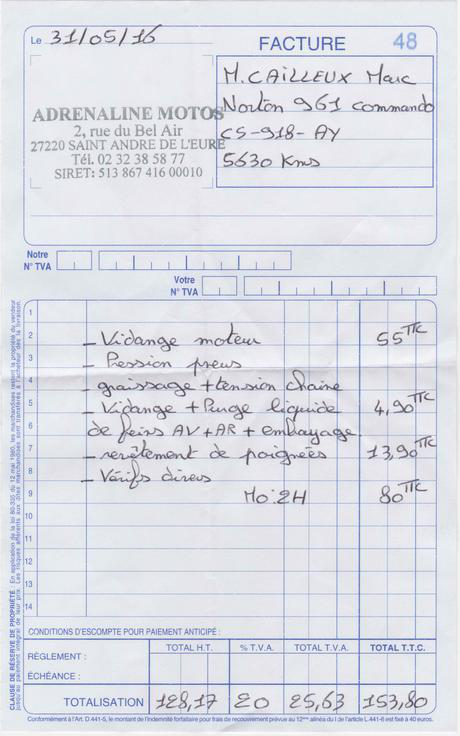

In [71]:
img = Image.open(document_file)
img

In [59]:
prompt = f"Génère un résumé de ce document: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3:medium")

print("\033[1;31;34m")
print(answer)


Résumé: La facture, datée du 31/05/16 et émise par Adrenaline Motos située à Saint André de l'Eure, mentionne les services suivants pour un total HT (Hors Taxes) de 48 euros : vidange moteur (55TTC), graissage + tension chaîne (5TTC), purge du liquide (4.90 TTC), remplacement des feins AV et AR ainsi que l'embrayage, revêtement des poignées (13.90 TTC) ainsi que diverses vérifications (8 TTC). 

Le montant total de la TVA est indiqué à 25,63 % ce qui porte le total TTC (Taxes Tout Compris) à 153,80 euros. La facture inclut également une clause réservée à l'utilisation des équipements vendus et des conditions d'escompte pour paiement anticipé conformément aux articles D:441-5 et L:4e41-1 du code général des impôts français.

La facture est émise par Marc Caillet, employé chez Adrenaline Motos avec le numéro de commando Norton 961. Le SIRET de l'entreprise est mentionné ainsi que les adresses postales et téléphoniques des deux parties.


In [60]:
prompt = f"Classifie ce document dans une catégorie: [ART], [VOYAGES], [IT], [PASSEPORT], [FACTURE]: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")

print("\033[1;31;34m")
print(answer)


Ce document peut être classifié dans la catégorie [FACTURE]. Le texte décrit un rapport de maintenance d'un véhicule, comme le Norton 961 Commando. L'information inclut des détails sur les vidanges moteur et diverses tâches réalisées lors du service ainsi que des informations fiscales liées à l'entreprise propriéeuse du véhicule.


In [63]:
prompt = f"Extrait le nom de la société et le nom du client: {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")

print("\033[1;31;34m")
print(answer)


Société : ADRENALINE MOTOS
Nom du client : Marc Cailleux

Note: Les informations extraites sont fournies dans le contexte de l'extrait fourni. Il est important de se rappeler que les numéros et détails fournis pourraient être un exemple fictif, car il n'y a pas dinasu de texte explicite contenant ces informations spécifiques.


In [65]:
prompt = f"Quel est le numéro de SIRET? {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")

print("\033[1;31;34m")
print(answer)


Le numéro de SIRET de l'entreprise "ADRENALINE MOTOS" mentionnée est le suivant : 513 867 416 00010.

Veuillez noter que cette information peut être utilisée uniquement à des fins d'études et de recherche, conformément aux lois sur la protection de l'information personnelle en France.


In [64]:
prompt = f"Quels sont les détails des différents services de cette facture? {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")

print("\033[1;31;34m")
print(answer)


Afin de vous aider à comprendre les détails de votre facture, voici une explication des différentes rubriques décrites :

Date de la facture: 31/05/2016.

Société facturante : ADERALINE MOTOS, adresse: 2 rue du Bel Air, Saint-Andre-de-l'Eure, France (Tel.: 0232 38 58 77; SIRET: 513 867 416 00010)

Destinataire de la facture : M. CAILLEUX Marc au Norton 961 (CS-918-AY ; Km parcourus : 5630 km).

TVA appliquée : Votre TVA n'est pas précisée dans le fichier de facture. Cependant, la société a retenu une TVA de 20%. La somme totale à payer est de 128,17 euros, dont 25,63 euros correspondent à l'impôt sur les revenus (TVA).

Services et coûts : Voici un résumé des différents services fournis avec leurs frais respectifs :

1. Vidange moteur - 55 TTC
2. Pression pneus, graissage et tension de la chaîne - 4,90 TTC
3. Entretien des feins (AV + AR), embrayage, révision des poignées - 13,90 TTC
4. Vérifications diverses (Vidange liquide, purge liquide) - Ingrédients du service sont indiqués au t

In [70]:
prompt = f"Quel est le TOTAL TTC et la date de la facture ? {ocr_text}"

answer = phi3_ollama_model(prompt, model="phi3")

print("\033[1;31;34m")
print(answer)


Le total TTC (Taux Temporaire des Contributions) de votre facture est de 153,80 €. La date de la facture est le 31/05/2016.

Veuillez noter que les informations suivantes ne sont pas directement liées au total TTC ou à la date de la facture :
- Adresse du service: 2, rue du Bel Air, Saint André de L'Eure, France (Code SIRET: 5138674160010)
- Nom et numéro d'immatriculation du véhicule: Marc Cailleux - Norton 961 Commando - CS-918-AY - 5630 km de parcours
- Services commandés: Videance moteur (55TTC), Pression pneus, graissage et tension chaine (4,90TTC), Vacuage + Purge liquide (4,90TTC), Remplacement des freins avant, arrière et embrayages (13,90TTC), Vérification de divers composants (5 TTC)
- Conditions d'échéance: Indice 2H - Échéance le 12 juin. Total H.T.: 128,17 € - TVA (20%): 25,63 € - Total TVA: 153,80 €
- Référence légale et règlement concernant les frais d'hors-service : Article D441-5 de la Loi n° 90/17 du 11 février 1990 relative à l'établissement des normes relatives aux

### Using ollama lib

In [ ]:
import ollama

In [ ]:
def phi3_ollama_lib_model(prompt, model="phi3"):
    """
    Sends a prompt to the 'phi3' model using the Ollama chat API and returns the response content.

    Args:
        prompt (str): The input prompt to be sent to the 'phi3' model.

    Returns:
        str: The content of the response message from the 'phi3' model.
    """
    try:
        response = ollama.chat(
            model,
            messages=[{
                'role': 'user',
                'content': prompt,
            }],
        )
        return response.message.content

    except Exception as e:
        print(f"'[Error] An error occurred: {e}")
        return None

In [ ]:
prompt = f"Generate a one line description for this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt, model="phi3:medium")
print(answer)

In [ ]:
prompt = f"Generate some keywords to describe this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print(answer)

In [ ]:
prompt = f"Classify this text into one of these categories: [ART], [TRAVEL], [FINANCE], [IT], [SPORTS] {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print(answer)

In [ ]:
prompt = f"What are the urls mentionned in this text: {ocr_text}"

answer = phi3_ollama_lib_model(prompt)
print(answer)